# Туториал по сохранению и продолжению обучения нейронной сети с демонстрацией на TensorBoard с применением туннелирования. 

#### Разбёрм принцип сохранения весов и продолжения обучения нейронной сети. Применять это можно для различных видов экспериментов, таких как чередование опртимизаторов для нахождения оптимальной составляющей сети, изменение архитектуры сети и подбор наиболее устойчивого строение сети. Плюсом является то, что в случае долгосрочного обучения сети не придётся начинать всё заново, если возникнет необходимость что-то изменить в модели нейронной сети. 

#### Для начала воспользуемся туннелированием, чтобы можно было воспользоваться TensorBoard ([link text](https://github.com/taomanwai/tensorboardcolab))

In [2]:
!pip install -U tensorboardcolab

  Running setup.py bdist_wheel for tensorboardcolab ... - done
  Stored in directory: /content/.cache/pip/wheels/ab/74/02/cda602d1dc28b2f12eab313c49b9bfa14d6371326bc2590e06
Successfully built tensorboardcolab


In [0]:
from tensorboardcolab import *

In [4]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://a039d529.ngrok.io


С помощью этой ссылки мы сможет отслеживать прогресс обучения нейронной сети.
Заменчание: если инициализация завершилась неудачей, увеличьте startup_waiting_time: 
tbc=TensorBoardColab(startup_waiting_time=30)

In [25]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10 # let's train NN with 10 epochs on GPU
data_augmentation = True
num_predictions = 20
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate Adamax optimizer due to the best results on this DataSet and Architecture
opt = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4,
                       callbacks=[TensorBoardColabCallback(tbc)])

# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 51s 32ms/step - loss: 1.6558 - acc: 0.3887 - val_loss: 1.2760 - val_acc: 0.5440
Epoch 2/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.3217 - acc: 0.5218 - val_loss: 1.0712 - val_acc: 0.6250
Epoch 3/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.1534 - acc: 0.5896 - val_loss: 0.9339 - val_acc: 0.6712
Epoch 4/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.0408 - acc: 0.6319 - val_loss: 0.9151 - val_acc: 0.6805
Epoch 5/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.9656 - acc: 0.6590 - val_loss: 0.8116 - val_acc: 0.7120
Epoch 6/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.9151 - acc: 0.6808 - val_loss: 0.7156 - val_acc: 0.7493
Epoch 7/10
1563/1563 [==============================] - 52s 33ms/step - loss

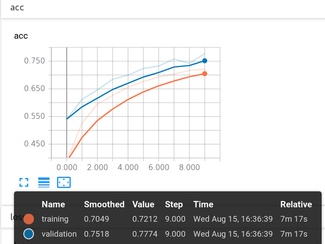

In [6]:
from IPython.display import Image
Image(filename='1.png')

#### Объясним, что произошло в "Save models and weights":
Фраймворк Keras может сохранять как архитектуру модели, так и уже обученные веса. Веса сохраняются в фомате HDF5, который идеально подходит для манипуляций с чесленными многомерными матрицами - тензонами. 
Структура модели может быть описана и сохранена в двух разных форматах: JSON и YAML.
#### Сохранение модели нейронной сети в JSON
####  JSON - иерархическая модель: 
{
   "firstName": "Иван",
   "lastName": "Иванов",
   "address": {
       "streetAddress": "Московское ш., 101, кв.101",
       "city": "Ленинград",
       "postalCode": "101101"
   },
   "phoneNumbers": [
       "812 123-1234",
       "916 123-4567"
   ]
}

#### Keras предоставляет возможность описать любую модель с использованием формата JSON с помощью функции to_json (). Таким образом, модель можно сохранить в файл, а затем загрузить через функцию model_from_json (), которая создаст новую модель из спецификации JSON.

Веса сохраняются непосредственно из модели с помощью функции save_weights (), а затем загружаются с использованием симметричной функции load_weights (), именно это мы и проделали. 

Данные модели и веса загружаются из сохраненных файлов, и создается новая модель. Очень важно скомпилировать загруженную модель до ее использования. 

#### Проверим, что всё сохранилось: 

In [30]:
ls -l

total 4936
drwxr-xr-x 3 root root    4096 Aug 13 21:16 datalab/
drwxr-xr-x 4 root root    4096 Aug 15 14:50 Graph/
-rw-r--r-- 1 root root 5038024 Aug 15 15:02 model.h5
-rw-r--r-- 1 root root    4971 Aug 15 15:02 model.json


#### Теперь загрузим модель и веса: 

In [31]:
from keras.models import load_model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


#### Продолжим обучение 

In [32]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://b2a0b755.ngrok.io


In [34]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
model_name = 'model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate Adamax optimizer
opt = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

# Let's train the model using RMSprop
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    loaded_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    loaded_model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4,
                       callbacks=[TensorBoardColabCallback(tbc)])

# serialize model to YAML
model_yaml = loaded_model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
loaded_model.save_weights("model.h5")
print("Saved model to disk")

# Score trained model.
scores = loaded_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6330 - acc: 0.7815 - val_loss: 0.5647 - val_acc: 0.8056
Epoch 2/10
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6274 - acc: 0.7817 - val_loss: 0.5686 - val_acc: 0.8041
Epoch 3/10
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6211 - acc: 0.7840 - val_loss: 0.5571 - val_acc: 0.8100
Epoch 4/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.6100 - acc: 0.7871 - val_loss: 0.5691 - val_acc: 0.8050
Epoch 5/10
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6088 - acc: 0.7893 - val_loss: 0.5691 - val_acc: 0.8037
Epoch 6/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.6009 - acc: 0.7908 - val_loss: 0.5683 - val_acc: 0.8072
Epoch 7/10
1563/1563 [==============================] - 51s 32ms/step - loss

#### После двухкратных итераций обучения по 10 эпох

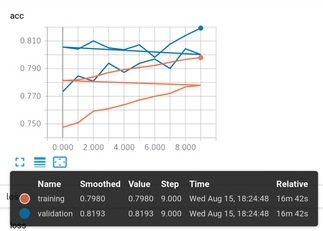

In [8]:
from IPython.display import Image
Image(filename='2.2.jpg')

#### В этом случае, мы сохранили модель в формате YAML:

Этот пример аналогичен приведенному выше примеру JSON, за исключением того, что формат YAML используется для спецификации модели.

Модель описывается с помощью YAML, сохраненной в файле model.yaml, а затем загружается в новую модель с помощью функции model_from_yaml (). Весы обрабатываются так же, как указано выше, в формате HDF5, как model.h5.

Пример: 

backend: theano
class_name: Sequential
config:
- class_name: Dense
  config:
    activation: relu
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 8]
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dtype: float32
    kernel_constraint: null
    kernel_initializer:
      class_name: RandomUniform
      config: {maxval: 0.05, minval: -0.05, seed: null}
    kernel_regularizer: null
    name: dense_1
    trainable: true
    units: 12
    use_bias: true

#### Так как мы работали с виртульной машиной на Google.Colab, то теперь нам нужно загрузить файлы с моделью на личный компьютер: 

In [0]:
from google.colab import files


In [0]:
files.download("model.yaml") 
files.download("model.h5") 

#### Вы также можете использовать model.save , чтобы сохранить модель Keras в один файл HDF5, который будет содержать:

     архитектура модели, позволяющая воссоздать модель
     веса модели
     конфигурация обучения (потеря, оптимизатор)
     состояние оптимизатора, позволяющее возобновить обучение именно там, где вы остановились.
   

Пример:

In [0]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

Если вам нужно сохранить архитектуру модели, а не ее веса или ее конфигурацию обучения, вы можете сделать следующее:

In [0]:
# save as JSON
json_string = model.to_json()

# save as YAML
yaml_string = model.to_yaml()

Если вам нужно сохранить веса модели, вы можете сделать это в HDF5 с помощью кода ниже.

In [0]:
"""
Assuming the original model looks like this:
    model = Sequential()
    model.add(Dense(2, input_dim=3, name='dense_1'))
    model.add(Dense(3, name='dense_2'))
    ...
    model.save_weights(fname)
"""

# new model
model = Sequential()
model.add(Dense(2, input_dim=3, name='dense_1'))  # will be loaded
model.add(Dense(10, name='new_dense'))  # will not be loaded

# load weights from first model; will only affect the first layer, dense_1.
model.load_weights(fname, by_name=True)